<a href="https://colab.research.google.com/github/albionaguri/cybersecurity/blob/main/UBA_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Synthetic Dataset Generation

#### Gaussian Noise

In [26]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

np.random.seed(42)

n_entries = 10000
users = [f"user_{i}" for i in range(1, 6)]
actions = ['login', 'file_access', 'database_query', 'password_change', 'logout']
ip_addresses = ['192.168.1.', '10.0.0.', '172.16.0.']

data = []
start_time = datetime(2024, 7, 31, 8, 0, 0)  # Start at 8 AM

# Define normal behavior patterns for each user
user_patterns = {
    'user_1': {'login_time': 8, 'logout_time': 17, 'favorite_action': 'file_access'},
    'user_2': {'login_time': 9, 'logout_time': 18, 'favorite_action': 'database_query'},
    'user_3': {'login_time': 7, 'logout_time': 16, 'favorite_action': 'file_access'},
    'user_4': {'login_time': 10, 'logout_time': 19, 'favorite_action': 'database_query'},
    'user_5': {'login_time': 8, 'logout_time': 17, 'favorite_action': 'file_access'}
}

for i in range(n_entries):
    user = np.random.choice(users)
    pattern = user_patterns[user]

    # Time-based patterns
    hour = np.random.randint(pattern['login_time'], pattern['logout_time'])
    timestamp = start_time.replace(hour=hour, minute=np.random.randint(0, 60))

    # Action based on user's normal behavior
    if np.random.random() < 0.6:  # 60% chance of favorite action
        action = pattern['favorite_action']
    else:
        action = np.random.choice([a for a in actions if a != pattern['favorite_action']])

    ip_address = np.random.choice(ip_addresses) + str(np.random.randint(1, 255))

    # Normal ranges for duration and bytes
    if action == 'file_access':
        duration = np.random.randint(5, 60)
        bytes_transferred = np.random.randint(1000, 10000)
    elif action == 'database_query':
        duration = np.random.randint(1, 30)
        bytes_transferred = np.random.randint(100, 1000)
    else:
        duration = np.random.randint(1, 10)
        bytes_transferred = np.random.randint(10, 100)

    # Add Gaussian noise to duration and bytes_transferred
    noise_duration = duration + np.random.normal(0, 5)
    noise_bytes_transferred = bytes_transferred + np.random.normal(0, 100)

    # Ensure duration and bytes_transferred are non-negative
    duration = max(0, noise_duration)
    bytes_transferred = max(0, noise_bytes_transferred)

    # Determine if the entry is an anomaly (0.1% - 1% chance)
    is_anomaly = np.random.random() < 0.03

    if is_anomaly:
        # Introduce more distinct anomalous behavior
        if action == 'login':
            ip_address = '203.0.113.' + str(np.random.randint(1, 255))  # Unknown IP
            hour = np.random.choice([h for h in range(24) if h < pattern['login_time'] - 1 or h > pattern['logout_time'] + 1])
        elif action == 'file_access':
            bytes_transferred = np.random.randint(50000, 100000)  # Unusually large file transfer
        elif action == 'database_query':
            duration = np.random.randint(100, 300)  # Unusually long query
        elif action == 'password_change':
            hour = np.random.randint(22, 24)  # Late night activity

    data.append({
        'timestamp': timestamp.replace(hour=hour),
        'user': user,
        'action': action,
        'ip_address': ip_address,
        'duration': duration,
        'bytes_transferred': bytes_transferred,
        'label': 'anomaly' if is_anomaly else 'normal'
    })

df = pd.DataFrame(data)
df = df.sort_values('timestamp')

print("\nSummary:")
print(f"Total entries: {len(df)}")
print(f"Normal entries: {len(df[df['label'] == 'normal'])}")
print(f"Anomaly entries: {len(df[df['label'] == 'anomaly'])}")


Summary:
Total entries: 10000
Normal entries: 9732
Anomaly entries: 268


In [27]:
df.head()

,timestamp,user,action,ip_address,duration,bytes_transferred,label
7077,2024-07-31 00:41:00,user_5,login,203.0.113.170,12.039344,0.000000,anomaly
7462,2024-07-31 00:54:00,user_3,login,203.0.113.139,7.089901,0.000000,anomaly
1147,2024-07-31 00:59:00,user_4,login,203.0.113.63,7.358326,76.158490,anomaly
6704,2024-07-31 01:03:00,user_2,login,203.0.113.223,2.490169,0.000000,anomaly
5178,2024-07-31 01:11:00,user_4,login,203.0.113.201,0.722501,87.135371,anomaly


## Pre-process   

In [28]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt


In [29]:
# Assuming we have already generated the DataFrame 'df' from the previous code

# 1. Prepare the data for clustering
# Select numerical features
features = ['duration', 'bytes_transferred']
X = df[features]

# Convert timestamp to hour and add it as a feature
X['hour'] = pd.to_datetime(df['timestamp']).dt.hour
X['hour'] = X['hour'].astype(float)

# Convert categorical variables to numerical
X['user'] = pd.Categorical(df['user']).codes
X['action'] = pd.Categorical(df['action']).codes
X['ip_subnet'] = df['ip_address'].apply(lambda x: x.split('.')[2]).astype(float)

# 2. Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

<ipython-input-29-bce39cff1c38>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['hour'] = pd.to_datetime(df['timestamp']).dt.hour
<ipython-input-29-bce39cff1c38>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['hour'] = X['hour'].astype(float)
<ipython-input-29-bce39cff1c38>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

### perform_clustering_and_evaluation

In [30]:
import pandas as pd
from sklearn.cluster import DBSCAN, KMeans
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

def perform_clustering_and_evaluation(df, X_scaled, model, model_name, label_col='label'):
    # Fit the model
    df[f'{model_name}_cluster'] = model.fit_predict(X_scaled)

    # Identify anomalies based on model
    if model_name == 'dbscan':
        df[f'is_anomaly_{model_name}'] = df[f'{model_name}_cluster'] == -1
    elif model_name == 'isolation_forest':
        df[f'is_anomaly_{model_name}'] = df[f'{model_name}_cluster'] == -1
    elif model_name == 'kmeans':
        # Calculate distances to cluster centers
        distances = kmeans.transform(X_scaled)
        df['distance_to_center'] = distances.min(axis=1)
        #  Define anomalies as points with distances greater than 2 standard deviations from the mean
        threshold = df['distance_to_center'].mean() + 2 * df['distance_to_center'].std()
        df[f'is_anomaly_{model_name}'] = df['distance_to_center'] > threshold


    # Compare results with original labels
    confusion_mat = pd.crosstab(df[label_col], df[f'is_anomaly_{model_name}'], rownames=['Actual'], colnames=['Predicted'])
    print(f"\nConfusion Matrix for {model_name}:")
    print(confusion_mat)

    # Calculate accuracy
    accuracy = (confusion_mat.loc['normal', False] + confusion_mat.loc['anomaly', True]) / len(df)
    print(f"\nAccuracy for {model_name}: {accuracy:.2f}")

    # Print summary statistics
    print("\nSummary Statistics:")
    print(f"Total entries: {len(df)}")
    print(f"Actual anomalies: {len(df[df[label_col] == 'anomaly'])}")
    print(f"Detected anomalies: {len(df[df[f'is_anomaly_{model_name}']])}")
    both_anomalies = df[(df[label_col] == 'anomaly') & (df[f'is_anomaly_{model_name}'])]
    print(f"Correctly identified anomalies: {len(both_anomalies)}")

    # Calculate and print precision, recall, and F1-score
    true_positives = len(both_anomalies)
    false_positives = len(df[df[f'is_anomaly_{model_name}']]) - true_positives
    false_negatives = len(df[df[label_col] == 'anomaly']) - true_positives

    precision = precision_score(df[label_col] == 'anomaly', df[f'is_anomaly_{model_name}'])
    recall = recall_score(df[label_col] == 'anomaly', df[f'is_anomaly_{model_name}'])
    f1 = f1_score(df[label_col] == 'anomaly', df[f'is_anomaly_{model_name}'])

    print("\nPerformance Metrics:")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-score: {f1:.2f}")

## K-means

In [31]:
from sklearn.cluster import KMeans
# Determine the optimal number of clusters using the elbow method
inertias = []
silhouette_scores = []
max_clusters = 10

for k in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

In [32]:
silhouette_scores

[0.26470134963771336,
 0.25614266473424857,
 0.2812026548517964,
 0.2656641049175415,
 0.25346230993029606,
 0.2568722915054226,
 0.2518130995119465,
 0.25522937605480805,
 0.25962179913226224]

In [33]:
df.head()

,timestamp,user,action,ip_address,duration,bytes_transferred,label
7077,2024-07-31 00:41:00,user_5,login,203.0.113.170,12.039344,0.000000,anomaly
7462,2024-07-31 00:54:00,user_3,login,203.0.113.139,7.089901,0.000000,anomaly
1147,2024-07-31 00:59:00,user_4,login,203.0.113.63,7.358326,76.158490,anomaly
6704,2024-07-31 01:03:00,user_2,login,203.0.113.223,2.490169,0.000000,anomaly
5178,2024-07-31 01:11:00,user_4,login,203.0.113.201,0.722501,87.135371,anomaly


In [34]:
X.head()

,duration,bytes_transferred,hour,user,action,ip_subnet
7077,12.039344,0.000000,0.0,4,2,113.0
7462,7.089901,0.000000,0.0,2,2,113.0
1147,7.358326,76.158490,0.0,3,2,113.0
6704,2.490169,0.000000,1.0,1,2,113.0
5178,0.722501,87.135371,1.0,3,2,113.0


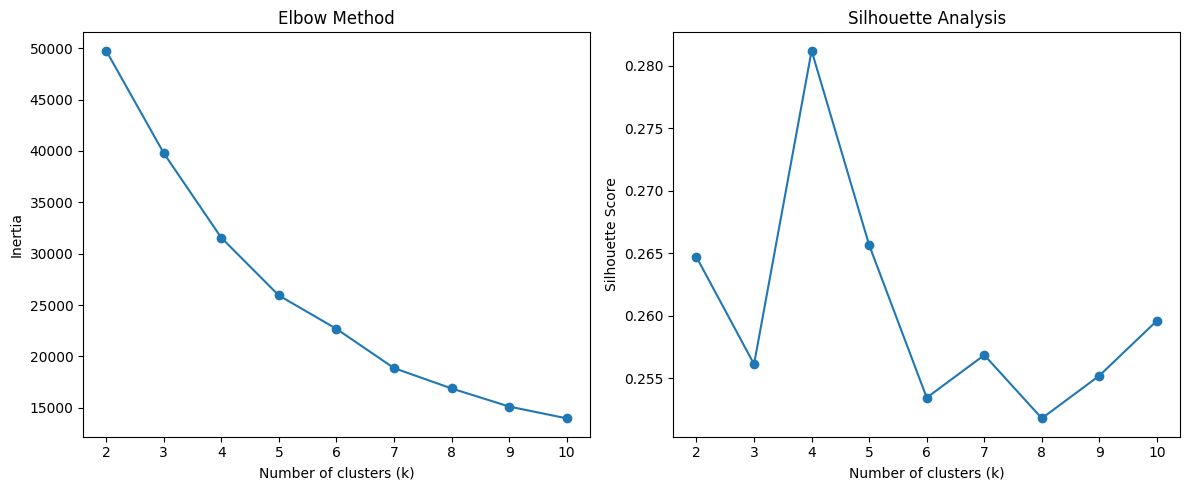

In [35]:

# Plot elbow curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(2, max_clusters + 1), inertias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')

# Plot silhouette scores
plt.subplot(1, 2, 2)
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')

plt.tight_layout()
plt.show()


In [95]:
# Choose the optimal number of clusters
optimal_k = 10

# Perform K-means clustering
# Best KMeans parameters: {'init': 'random', 'n_clusters': 10, 'n_init': 20}

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=20, init='random')
perform_clustering_and_evaluation(df, X_scaled, kmeans,'kmeans')



Confusion Matrix for kmeans:
Predicted  False  True 
Actual                 
anomaly       87    181
normal      9647     85

Accuracy for kmeans: 0.98

Summary Statistics:
Total entries: 10000
Actual anomalies: 268
Detected anomalies: 266
Correctly identified anomalies: 181

Performance Metrics:
Precision: 0.68
Recall: 0.68
F1-score: 0.68


## PCA

In [37]:
# 2. Plot visualizing clusters, real anomalies, and detected anomalies
# Apply PCA for 2D visualization
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

## Visualize

####  plot_2D_anomalies

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_2D_anomalies(df, X_pca, cluster_col, is_anomaly_col, title):

  """
    Plot of anomalies and clusters.

    Parameters:
    - df: DataFrame containing the data and labels.
    - X_pca: PCA-transformed data.
    - cluster_col: Column name for cluster labels.
    - is_anomaly_col: Column name for anomaly labels.
    - title: Title for the plots.
  """
  # 1. Plot showing actual anomalies on quantitative variables
  plt.figure(figsize=(12, 8))
  scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df[cluster_col], cmap='viridis', alpha=0.7)
  plt.colorbar(scatter, label='Cluster')
  plt.scatter(X_pca[df['label'] == 'anomaly', 0],
              X_pca[df['label'] == 'anomaly', 1],
              color='red', marker='o', s=100, facecolors='none', label='Actual Anomalies')
  plt.xlabel('Duration')
  plt.ylabel('Bytes Transferred')
  plt.title(title)
  plt.legend()
  plt.show()

  plt.figure(figsize=(12, 8))
  scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df[cluster_col], cmap='viridis', alpha=0.7)
  plt.colorbar(scatter)
  plt.scatter(X_pca[df[is_anomaly_col], 0], X_pca[df[is_anomaly_col], 1],
              color='red', marker='x', s=100, label='Detected Anomalies')
  plt.xlabel('Duration')
  plt.ylabel('Bytes Transferred')
  plt.title(title)
  plt.legend()
  plt.show()

  plt.figure(figsize=(15, 10))
  # Plot all points
  scatter = plt.scatter(X_pca[:, 0], X_pca[:,1], c=df[cluster_col], cmap='viridis', alpha=0.5)
  plt.colorbar(scatter, label='Cluster')

  # Plot actual anomalies
  plt.scatter(X_pca[df['label'] == 'anomaly', 0],  X_pca[df['label'] == 'anomaly', 1],
              color='red', marker='o', s=100, facecolors='none', label='Actual Anomalies')


  # Plot detected anomalies
  plt.scatter(X_pca[df[is_anomaly_col], 0],
              X_pca[df[is_anomaly_col], 1],
              color='blue', marker='x', s=100, label='Detected Anomalies')

  # Highlight points that are both actual and detected anomalies
  both_anomalies = df[(df['label'] == 'anomaly') & (df[is_anomaly_col])]
  plt.scatter(X_pca[both_anomalies.index, 0], X_pca[both_anomalies.index, 1],
              color='purple', marker='*', s=150, label='Actual & Detected Anomalies')

  plt.xlabel('Duration')
  plt.ylabel('Bytes Transferred')
  plt.title(title)
  plt.legend()
  plt.show()


In [39]:
df.columns

Index(['timestamp', 'user', 'action', 'ip_address', 'duration',
       'bytes_transferred', 'label', 'kmeans_cluster', 'distance_to_center',
       'is_anomaly_kmeans'],
      dtype='object')

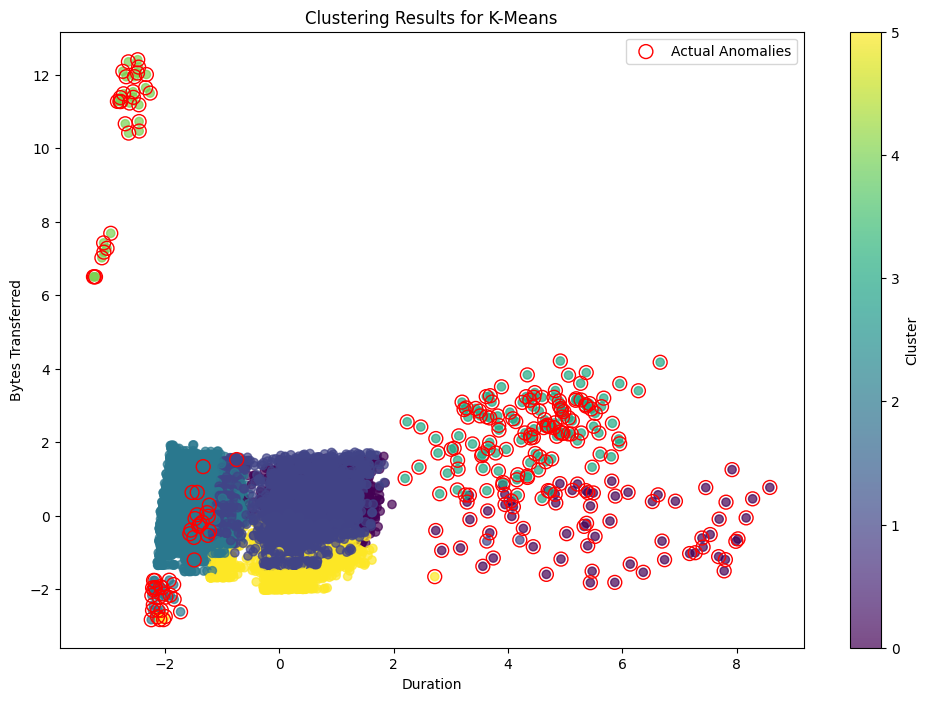

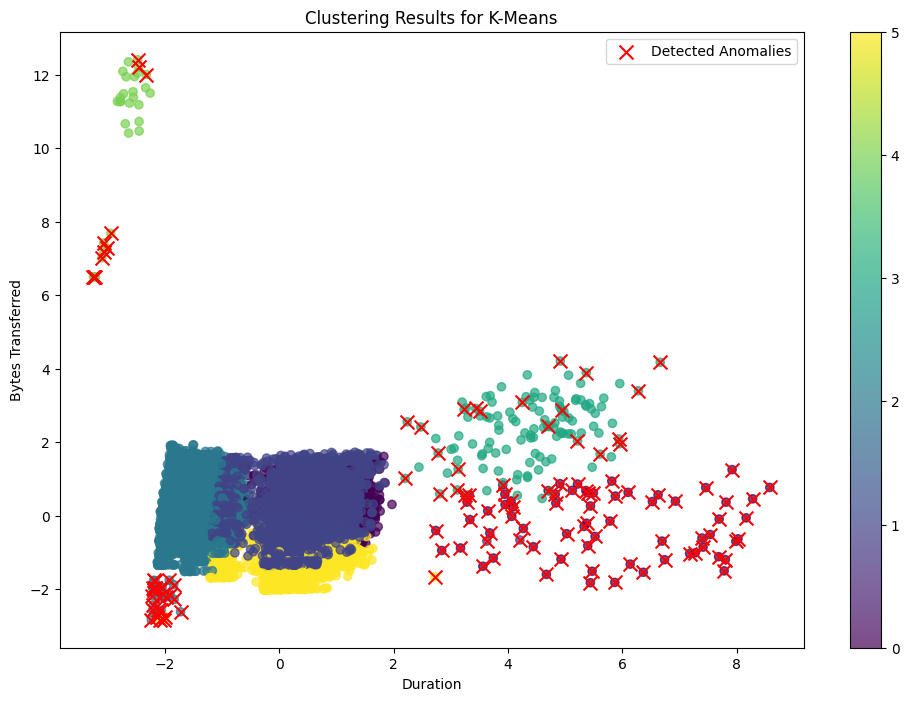

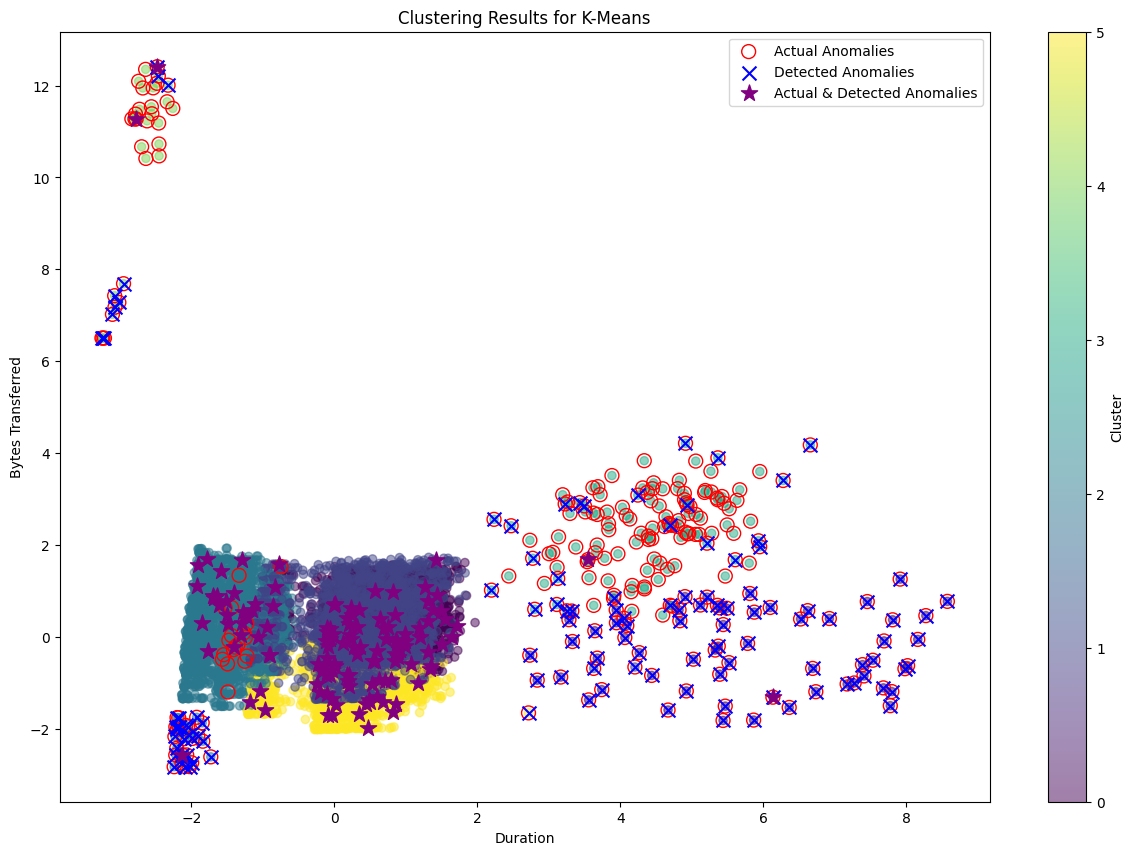

In [40]:
plot_2D_anomalies(df, X_pca, 'kmeans_cluster', 'is_anomaly_kmeans', 'Clustering Results for K-Means')


In [41]:
# 10. Print some example anomalies
print("\nExample Detected Anomalies:")
df[df['is_anomaly_kmeans']].head(4)


Example Detected Anomalies:


,timestamp,user,action,ip_address,duration,bytes_transferred,label,kmeans_cluster,distance_to_center,is_anomaly_kmeans
7077,2024-07-31 00:41:00,user_5,login,203.0.113.170,12.039344,0.00000,anomaly,4,3.163773,True
7462,2024-07-31 00:54:00,user_3,login,203.0.113.139,7.089901,0.00000,anomaly,4,2.821092,True
1147,2024-07-31 00:59:00,user_4,login,203.0.113.63,7.358326,76.15849,anomaly,4,2.907597,True
5076,2024-07-31 07:11:00,user_3,file_access,172.16.0.236,62.266050,99766.00000,anomaly,3,3.524626,True


In [42]:
X.head()

,duration,bytes_transferred,hour,user,action,ip_subnet
7077,12.039344,0.000000,0.0,4,2,113.0
7462,7.089901,0.000000,0.0,2,2,113.0
1147,7.358326,76.158490,0.0,3,2,113.0
6704,2.490169,0.000000,1.0,1,2,113.0
5178,0.722501,87.135371,1.0,3,2,113.0


#### Determine optimal epsilon using k-distance graph

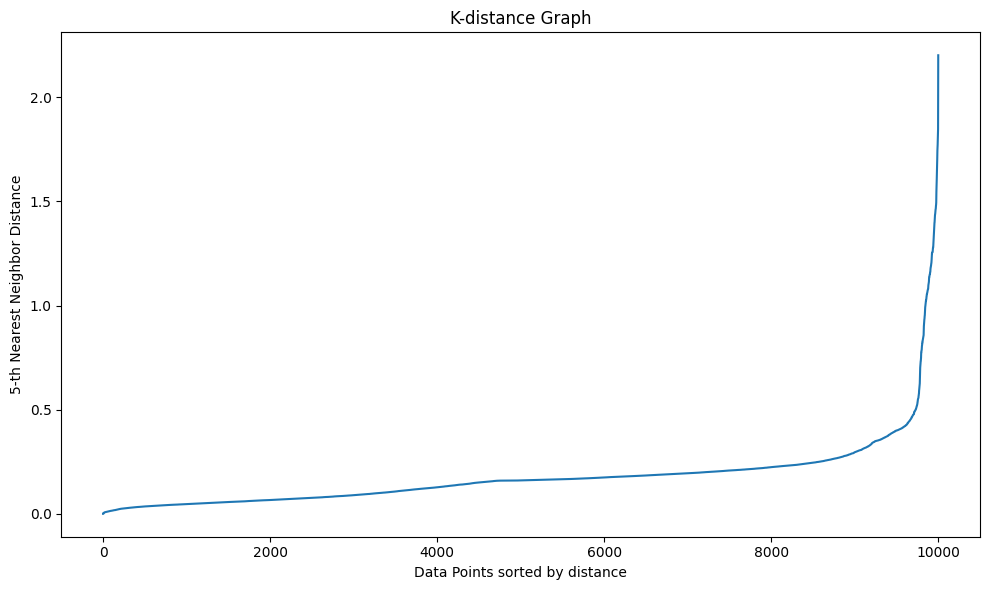

In [43]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

# Determine optimal epsilon using k-distance graph
k = 5  # number of neighbors
neigh = NearestNeighbors(n_neighbors=k)
nbrs = neigh.fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)

# Sort and plot k-distance graph
distances = np.sort(distances[:, k-1])
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('K-distance Graph')
plt.xlabel('Data Points sorted by distance')
plt.ylabel(f'{k}-th Nearest Neighbor Distance')
plt.tight_layout()
plt.show()

## DBSCAN

In [85]:
# DBSCAN
# Best Parameters: eps = 0.9, min_samples = 5
epsilon =  0.9
dbscan = DBSCAN(eps=epsilon, min_samples=k)
perform_clustering_and_evaluation(df, X_scaled, dbscan, 'dbscan')


Confusion Matrix for dbscan:
Predicted  False  True 
Actual                 
anomaly       55    213
normal      9732      0

Accuracy for dbscan: 0.99

Summary Statistics:
Total entries: 10000
Actual anomalies: 268
Detected anomalies: 213
Correctly identified anomalies: 213

Performance Metrics:
Precision: 1.00
Recall: 0.79
F1-score: 0.89


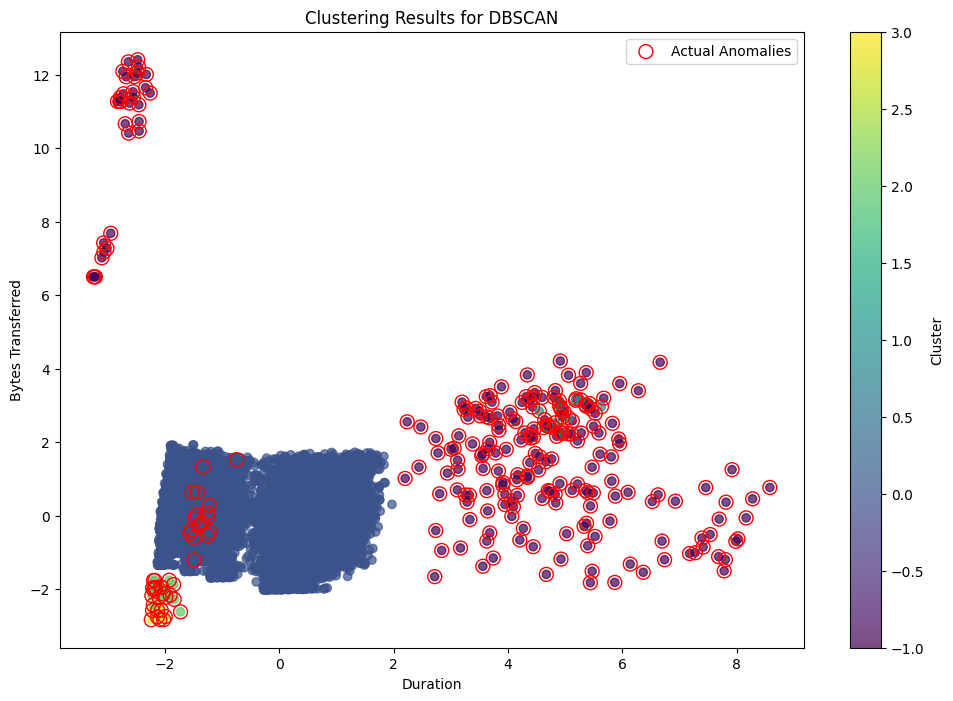

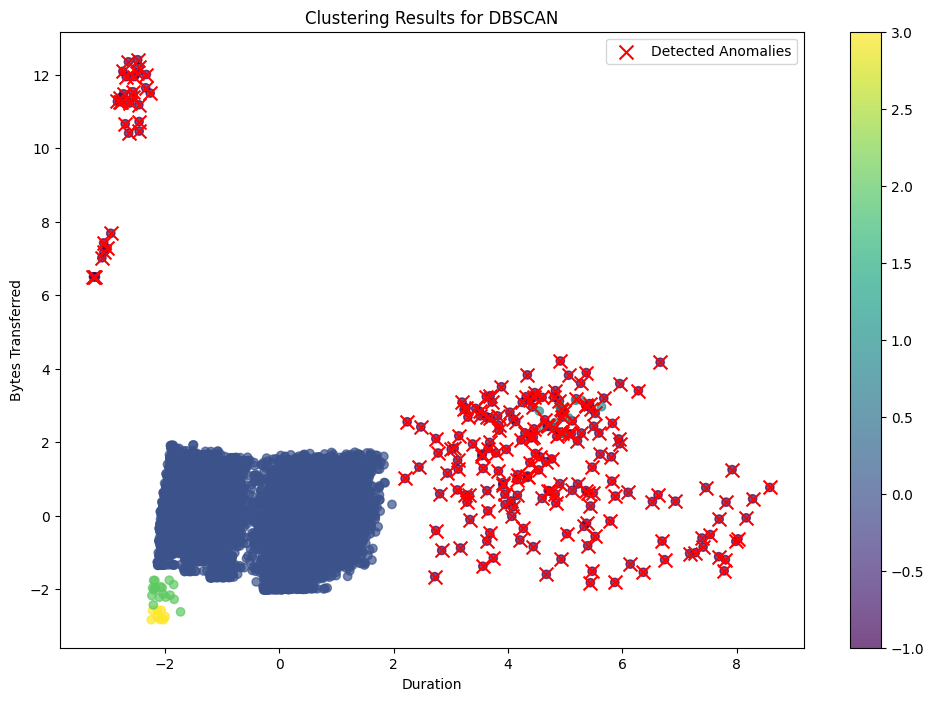

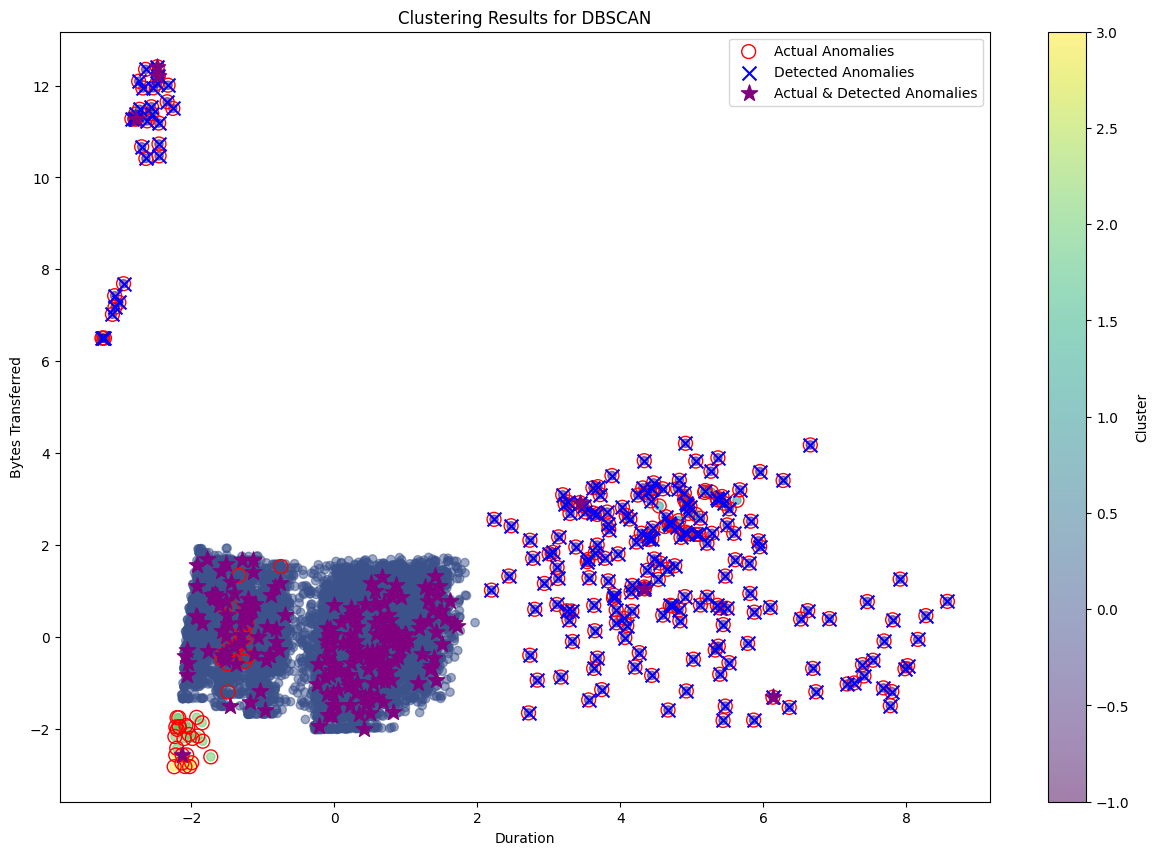

In [86]:
plot_2D_anomalies(df, X_pca, 'dbscan_cluster', 'is_anomaly_dbscan', 'Clustering Results for DBSCAN')

In [87]:
# Print some example anomalies
print("\nExample Detected Anomalies:")
df[df['is_anomaly_dbscan']].head(4)


Example Detected Anomalies:


,timestamp,user,action,ip_address,duration,bytes_transferred,label,kmeans_cluster,distance_to_center,is_anomaly_kmeans,dbscan_cluster,is_anomaly_dbscan,isolation_forest_cluster,is_anomaly_isolation_forest,dbscan_anomaly,iso_forest_cluster,iso_forest_anomaly
7077,2024-07-31 00:41:00,user_5,login,203.0.113.170,12.039344,0.00000,anomaly,2,3.163773,True,-1,True,1,False,True,-1,True
7462,2024-07-31 00:54:00,user_3,login,203.0.113.139,7.089901,0.00000,anomaly,2,2.821092,True,-1,True,1,False,True,-1,True
1147,2024-07-31 00:59:00,user_4,login,203.0.113.63,7.358326,76.15849,anomaly,2,2.907597,True,-1,True,1,False,True,-1,True
6704,2024-07-31 01:03:00,user_2,login,203.0.113.223,2.490169,0.00000,anomaly,2,2.572846,False,-1,True,1,False,True,-1,True


In [88]:
df.columns

Index(['timestamp', 'user', 'action', 'ip_address', 'duration',
       'bytes_transferred', 'label', 'kmeans_cluster', 'distance_to_center',
       'is_anomaly_kmeans', 'dbscan_cluster', 'is_anomaly_dbscan',
       'isolation_forest_cluster', 'is_anomaly_isolation_forest',
       'dbscan_anomaly', 'iso_forest_cluster', 'iso_forest_anomaly'],
      dtype='object')

## ISOLATION FOREST

In [93]:
from sklearn.ensemble import IsolationForest

# Apply Isolation Forest
# Best parameters: {'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 50}


iso_forest = IsolationForest(contamination=0.01, random_state=42, max_samples= 0.5, max_features=1.0, n_estimators=50)
perform_clustering_and_evaluation(df, X_scaled, iso_forest, 'isolation_forest')


Confusion Matrix for isolation_forest:
Predicted  False  True 
Actual                 
anomaly      168    100
normal      9732      0

Accuracy for isolation_forest: 0.98

Summary Statistics:
Total entries: 10000
Actual anomalies: 268
Detected anomalies: 100
Correctly identified anomalies: 100

Performance Metrics:
Precision: 1.00
Recall: 0.37
F1-score: 0.54


In [49]:
df['isolation_forest_cluster'].nunique()

2

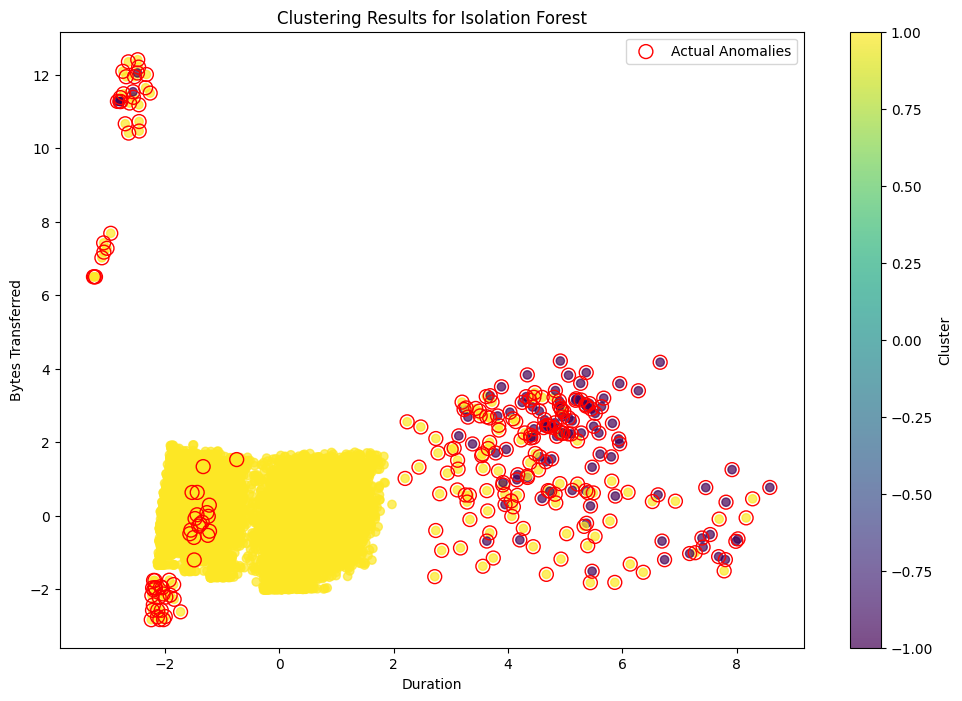

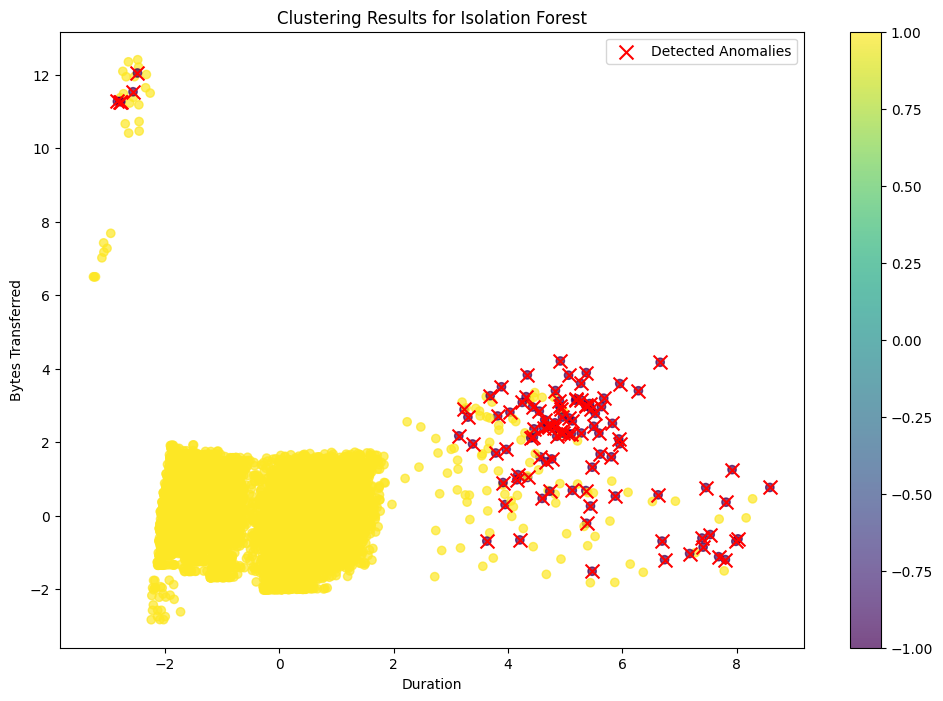

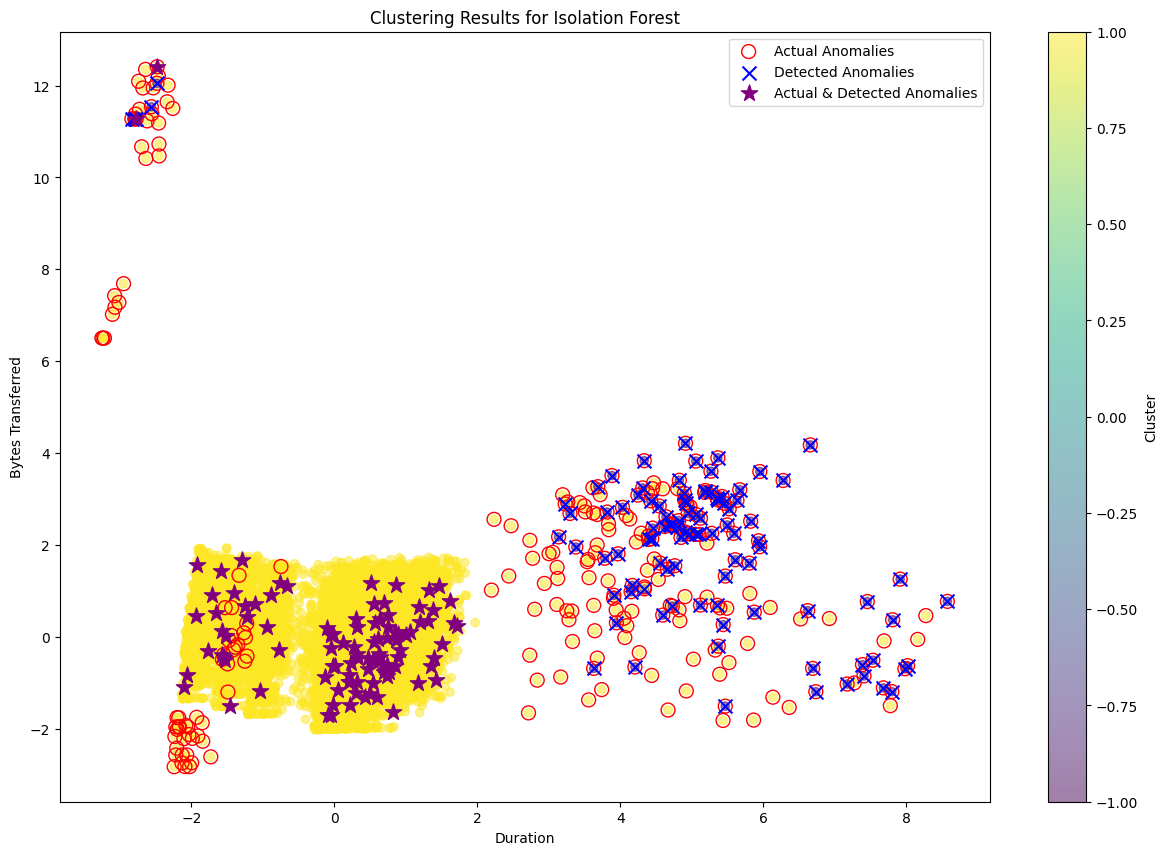

In [50]:
plot_2D_anomalies(df, X_pca, 'isolation_forest_cluster', 'is_anomaly_isolation_forest', 'Clustering Results for Isolation Forest')

## Hyperparameter tuning

### K-Means

In [60]:
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans

# Define the parameter grid
param_grid_kmeans = {
    'n_clusters': range(2, 11),  # Testing cluster sizes from 2 to 10
    'init': ['k-means++', 'random'],
    'n_init': [10, 20]  # Number of initializations
}

# Create a KMeans model
kmeans = KMeans(random_state=42)

# Set up GridSearchCV
grid_search_kmeans = GridSearchCV(estimator=kmeans, param_grid=param_grid_kmeans, cv=5)

# Fit the model
grid_search_kmeans.fit(X_scaled)

# Get the best parameters
best_kmeans_params = grid_search_kmeans.best_params_
print(f"Best KMeans parameters: {best_kmeans_params}")

# Evaluate the best model using silhouette score
best_kmeans = KMeans(**best_kmeans_params, random_state=42)
best_kmeans.fit(X_scaled)
silhouette_score = silhouette_score(X_scaled, best_kmeans.labels_)
print(f"Silhouette Score: {silhouette_score:.2f}")

Best KMeans parameters: {'init': 'random', 'n_clusters': 10, 'n_init': 20}
Silhouette Score: 0.26


### DBSCAN

In [77]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import numpy as np

# Define the hyperparameter space for DBSCAN
eps_values = np.arange(0.1, 1.1, 0.1)
min_samples_values = np.arange(2, 11, 1)

# Initialize variables to store the best hyperparameters and score
best_eps = None
best_min_samples = None
best_silhouette = -1

# Iterate over different combinations of hyperparameters
for eps in eps_values:
    for min_samples in min_samples_values:
        # Initialize the DBSCAN model with the current hyperparameters
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)

        # Perform clustering
        dbscan.fit(X_scaled)
        labels = dbscan.labels_

        # Calculate the silhouette score
        silhouette = silhouette_score(X_scaled, labels)

        # Update the best hyperparameters and score if the current score is better
        if silhouette > best_silhouette:
            best_silhouette = silhouette
            best_eps = eps
            best_min_samples = min_samples

# Print the best hyperparameters and score
print("Best Parameters: eps = {}, min_samples = {}".format(best_eps, best_min_samples))
print("Best Silhouette Score: ", best_silhouette)

# Initialize the best DBSCAN model with the tuned hyperparameters
best_dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)

# Use the best DBSCAN model to cluster the data
best_dbscan.fit(X_scaled)
labels = best_dbscan.labels_

# Evaluate the clustering performance using calinski-harabasz index. metric used to evaluate the quality of clustering.
# It measures the ratio of the between-cluster variance to the within-cluster variance, with higher values indicating better clustering.
calinski = calinski_harabasz_score(X_scaled, labels)
print("Calinski-Harabasz Index: ", calinski)

Best Parameters: eps = 0.9, min_samples = 5
Best Silhouette Score:  0.40824668353492666
Calinski-Harabasz Index:  345.28118124364255


### Isolation forest

In [68]:
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import IsolationForest

# Custom scoring function for unsupervised learning
def unsupervised_scorer(estimator, X):
    # Predict the anomaly scores
    scores_pred = estimator.decision_function(X)

     # Classify points as normal or anomalous based on the contamination threshold
    labels = scores_pred < estimator.contamination

    # Compute the silhouette score
    try:
        silhouette = silhouette_score(X, labels)
        # Check if the silhouette score is NaN
        if np.isnan(silhouette):
            return -1  # Return a default value for NaN (you can choose another value if preferred)
        return silhouette
    except ValueError:
        # Handle cases where silhouette score cannot be computed
        return -1  # Return a default value for errors

    # Compute the silhouette score
    silhouette = silhouette_score(X, scores_pred < estimator.contamination)
    return silhouette

# Initialize the Isolation Forest model with contamination parameter
iso_forest = IsolationForest(contamination=0.01, random_state=42)

# Define a range of parameters to tune, excluding the contamination parameter
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_samples': [0.25, 0.5, 0.75],
    'max_features': [1.0, 0.7, 0.5]
}

# Set up the grid search with the custom scorer
grid_search = GridSearchCV(estimator=iso_forest, param_grid=param_grid, scoring=unsupervised_scorer, cv=5, n_jobs=-1)

# Fit the model
grid_search.fit(X_scaled)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")

# the best estimator for further analysis
best_iso_forest = grid_search.best_estimator_

Best parameters: {'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 50}
Best score: 0.7766405050223023
